#Install packages

In [1]:
!pip install tensorflow-addons
!pip install transformers
!pip install --upgrade gensim==3.8.3
!pip install -q tf-models-official==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 36.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 39.8 MB/s 
     |████████████████████████████████| 6.6 MB 57.9 MB/s 
     |████████████████████████████████| 596 kB 56.5 MB/s 
     |████████████████████████████████| 86 kB 2.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.2 MB 3.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.8 MB 14.3 MB/s

#Import libraries

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import pickle as pk
import pandas as pd
import numpy as np
import random, os

from transformers import TFAutoModel, AutoTokenizer
from google.colab import drive
from pathlib import Path


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from transformers import AutoModel, AutoTokenizer, TFAutoModel

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#Load datasets

In [3]:
FB_RO_OFFENSE_PATH = Path('/content/drive/MyDrive/Licenta_Busuioc_Gabriel-Razvan_2022/corpora/FB-RO-Offense')
RO_OFFENSE_PATH = Path('/content/drive/MyDrive/Licenta_Busuioc_Gabriel-Razvan_2022/corpora/RO-Offense')

df_trainRO = pd.read_csv(RO_OFFENSE_PATH / 'train_internal.csv')
df_testRO = pd.read_csv(RO_OFFENSE_PATH / 'test.csv')
df_validateRO = pd.read_csv(RO_OFFENSE_PATH / 'validation_internal.csv')
df_trainFBRO = pd.read_csv(FB_RO_OFFENSE_PATH / 'train_internal.csv')
df_testFBRO = pd.read_csv(FB_RO_OFFENSE_PATH / 'test.csv')
df_validateFBRO = pd.read_csv(FB_RO_OFFENSE_PATH / 'validation_internal.csv')

labelCodificationMap = {"OTHER":0, "PROFANITY":1, "INSULT":2, "ABUSE":3}

x_trainRO, y_trainRO = df_trainRO.text, df_trainRO.label.map(labelCodificationMap)
x_validateRO, y_validateRO = df_validateRO.text, df_validateRO.label.map(labelCodificationMap)
x_testRO, y_testRO = df_testRO.text, df_testRO.label.map(labelCodificationMap)

x_trainFBRO, y_trainFBRO = df_trainFBRO.text, df_trainFBRO.label.map(labelCodificationMap)
x_validateFBRO, y_validateFBRO = df_validateFBRO.text, df_validateFBRO.label.map(labelCodificationMap)
x_testFBRO, y_testFBRO = df_testFBRO.text, df_testFBRO.label.map(labelCodificationMap)


#Load

In [4]:
tokenizer = AutoTokenizer.from_pretrained("readerbench/RoBERT-base")
bert = TFAutoModel.from_pretrained("readerbench/RoBERT-base")


Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/468 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/554M [00:00<?, ?B/s]

Some layers from the model checkpoint at readerbench/RoBERT-base were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at readerbench/RoBERT-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#Test Data


In [ ]:
tokLen = 50

X_testFBRO = tokenizer(x_testFBRO.tolist(), padding='max_length', return_tensors="np", truncation=True, max_length=tokLen)
print(X_testFBRO)
X_testFBRO = list(X_testFBRO.values())
Y_testFBRO = tf.one_hot(y_testFBRO, depth=4)

X_testTRANSF = tokenizer(x_testFBRO.tolist(), padding='max_length', return_tensors="np", truncation=True, max_length=tokLen)
X_testTRANSF = list(X_testTRANSF.values())
Y_testTRANSF = tf.one_hot(y_testFBRO, depth=4)

{'input_ids': array([[   3, 4554,   71, ...,    0,    0,    0],
       [   3, 1183, 6033, ...,    0,    0,    0],
       [   3,  124,   18, ...,    0,    0,    0],
       ...,
       [   3,   23,  203, ...,    0,    0,    0],
       [   3, 2087,   27, ...,    0,    0,    0],
       [   3,  157,  124, ...,    0,    0,    0]]), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}


#Load model


In [ ]:
modelPath = '/content/drive/MyDrive/Licenta_Busuioc_Gabriel-Razvan_2022/BERT-CNN-FBRO_0.844_50.h5'

model = tf.keras.models.load_model(modelPath)


In [ ]:
model.summary()

#ERROR ANALYSIS


In [6]:
!install csv

install: missing destination file operand after 'csv'
Try 'install --help' for more information.


In [7]:
labelCodificationMap = {0:"OTHER", 1:"PROFANITY", 2:"INSULT", 3:"ABUSE"}
def decodeLabel(numberLabel):
  return labelCodificationMap[numberLabel]

In [9]:
import csv
import os

modelsPath = ["/content/drive/MyDrive/Licenta_Busuioc_Gabriel-Razvan_2022/BERT-CNN-FBRO_0.844_50.h5",
              "/content/drive/MyDrive/Licenta_Busuioc_Gabriel-Razvan_2022/BERT-CNN-TRANSF_0.819_120.h5",
              "/content/drive/MyDrive/Licenta_Busuioc_Gabriel-Razvan_2022/BERT_FBRO_0.755_16_30_32.h5",
              "/content/drive/MyDrive/Licenta_Busuioc_Gabriel-Razvan_2022/BERT_TRANSF_0.755_128_120_128.h5"]
tokenizerLens = [50, 120, 30, 120]
learningKind = ["FBRO", "TRANSF", "FBRO", "TRANSF"]

for modelPath, tokLen, kind in zip(modelsPath, tokenizerLens, learningKind):

  X_testFBRO = tokenizer(x_testFBRO.tolist(), padding='max_length', return_tensors="np", truncation=True, max_length=tokLen)
  X_testFBRO = list(X_testFBRO.values())
  Y_testFBRO = tf.one_hot(y_testFBRO, depth=4)

  X_testTRANSF = tokenizer(x_testFBRO.tolist(), padding='max_length', return_tensors="np", truncation=True, max_length=tokLen)
  X_testTRANSF = list(X_testTRANSF.values())
  Y_testTRANSF = tf.one_hot(y_testFBRO, depth=4)


  XTEST = None
  YTEST = None
  if kind == "FBRO":
    XTEST = X_testFBRO
    YTEST = Y_testFBRO
  if kind == "TRANSF":
    XTEST = X_testTRANSF
    YTEST = Y_testTRANSF

  model = tf.keras.models.load_model(modelPath)

  predictions = model.predict(XTEST)

  file = open(modelPath+".predictions", "w")
  writer = csv.writer(file)
  writer.writerow(["text", "prediction", "trueLabel"])
  for prediction, text, trueLabel in zip(predictions, x_testFBRO.tolist(), y_testFBRO):
    index = tf.argmax(prediction, axis=0)
    writer.writerow([text, decodeLabel(index.numpy()), decodeLabel(trueLabel)])
  file.close()

#MANUAL TESTING


In [28]:
import csv
import os

modelsPath = ["/content/drive/MyDrive/Licenta_Busuioc_Gabriel-Razvan_2022/BERT-CNN-FBRO_0.844_50.h5",
              "/content/drive/MyDrive/Licenta_Busuioc_Gabriel-Razvan_2022/BERT-CNN-TRANSF_0.819_120.h5",
              "/content/drive/MyDrive/Licenta_Busuioc_Gabriel-Razvan_2022/BERT_FBRO_0.755_16_30_32.h5",
              "/content/drive/MyDrive/Licenta_Busuioc_Gabriel-Razvan_2022/BERT_TRANSF_0.755_128_120_128.h5"]
tokenizerLens = [50, 120, 30, 120]
learningKind = ["FBRO", "TRANSF", "FBRO", "TRANSF"]
texts = ["baga-ti-as surubul in piulita!",
         "sa-ti bag lebarul in sacosa!",
         "ce pula mea mai e de facut in cazul asta?",
         "sa-mi bag pula in toata ma-ta si in mortii ei!",
         "du-te dracu de aici ca esti chiar dobitoc",
         "daca esti prost de mic, cand esti mare doar te joci",
         "mars la cotet, javra ce esti!",
         "astia chiar ne cred asa prosti?",
         "sunteti niste prapaditi!",
         "sa-mi iei ouale in gura!",
         "sa-ti dau tot pixul sa il sugi",
         "grijania mă-tii de copil",
         "sa iti iau mortii la dans!",
         "sa-mi iei p..a in gura",
         "sa-mi iei pu....l..a in gura",
         "ce bozgoer esti...",
         "esti un bolsevic",
         "ma-ta este foarte frumoasa!",
         "sa-ti bag banii la cec!",
         "canta-mi-ai la ce atarna",
         "sa-mi lingi banana!",
         "sa-mi fac schiuri din crucea ma-tii",
         "vopsi-mi-ai ouale!"
         ]

trueLabels = [3, 3, 1, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3]


for modelPath, tokLen, kind in zip(modelsPath, tokenizerLens, learningKind):

  XTEST = tokenizer(texts, padding='max_length', return_tensors="np", truncation=True, max_length=tokLen)
  XTEST = list(XTEST.values())
  # Y_testFBRO = tf.one_hot(y_testFBRO, depth=4)

  # X_testTRANSF = tokenizer(x_testFBRO.tolist(), padding='max_length', return_tensors="np", truncation=True, max_length=tokLen)
  # X_testTRANSF = list(X_testTRANSF.values())
  # Y_testTRANSF = tf.one_hot(y_testFBRO, depth=4)


  # XTEST = None
  # YTEST = None
  # if kind == "FBRO":
  #   XTEST = X_testFBRO
  #   YTEST = Y_testFBRO
  # if kind == "TRANSF":
  #   XTEST = X_testTRANSF
  #   YTEST = Y_testTRANSF

  model = tf.keras.models.load_model(modelPath)

  predictions = model.predict(XTEST)

  file = open(modelPath+".manual.csv", "w")
  writer = csv.writer(file)
  writer.writerow(["text", "prediction", "trueLabel"])
  for prediction, text, trueLabel in zip(predictions, texts, trueLabels):
    index = tf.argmax(prediction, axis=0)
    writer.writerow([text, decodeLabel(index.numpy()), decodeLabel(trueLabel)])
  file.close()

#TEST MODELS


In [ ]:
texts = ["ce dracu zici acolo?", "sa iti bag surubul in piulita!"]
test = tokenizer(texts, padding='max_length', return_tensors="np", truncation=True, max_length=tokLen)
test = list(test.values())
predictions = model.predict(test);
print(predictions)
for text, predicted in zip(texts, predictions):
  index = tf.argmax(predicted, axis=0)
  print(text + " - " + decodeLabel(index.numpy()))

[[2.8204615e-04 9.9229383e-01 5.0051361e-03 2.4189851e-03]
 [6.2692612e-02 7.6636230e-03 5.4815993e-02 8.7482774e-01]]
ce dracu zici acolo? - PROFANITY
sa iti bag surubul in piulita! - ABUSE


# METRICS FOR THESIS

In [ ]:
from sklearn import metrics
import seaborn as sns

In [ ]:
XTEST = X_testTRANSF 
YTEST = Y_testTRANSF 

# XTEST = X_testFBRO
# YTEST = Y_testFBRO

In [ ]:
def prettyPrint(metrics):
  print("FG Accuracy=",metrics[1])
  print("FG Precision=",metrics[2])
  print("FG Recall=",metrics[3])
  print("FG F1 Micro=",metrics[4])
  print("FG F1 Macro=",metrics[5])
  print("CG Accuracy=",metrics[6])
  print("CG Precision=",metrics[7])
  print("CG Recall=",metrics[8])
  print("CG F1=",metrics[9])

results = model.evaluate(XTEST, YTEST, verbose=1)

y_pred = model.predict(XTEST)
y_predCG = pd.Series(tf.argmax(y_pred, 1)).map({0:0, 1:1, 2:1, 3:1})
Y_testCG = pd.Series(tf.argmax(YTEST, 1)).map({0:0, 1:1, 2:1, 3:1})

CGaccuracy = metrics.accuracy_score(Y_testCG, y_predCG)
CGprecision = metrics.precision_score(Y_testCG, y_predCG)
CGrecall = metrics.recall_score(Y_testCG, y_predCG)
CGf1 = metrics.f1_score(Y_testCG, y_predCG)

prettyPrint(results + [CGaccuracy, CGprecision, CGrecall, CGf1])

[Text(0, 0.5, 'OTHER'),
 Text(0, 1.5, 'PROFANITY'),
 Text(0, 2.5, 'INSULT'),
 Text(0, 3.5, 'ABUSE')]

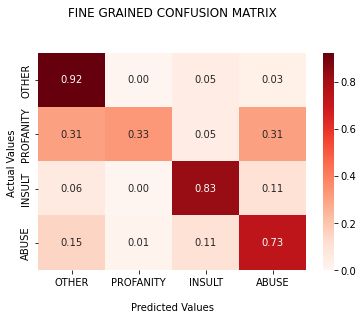

In [ ]:
YPRED = [tf.argmax(predicted, axis=0).numpy() for predicted in y_pred]
YTEST_SAN = [tf.argmax(predicted, axis=0).numpy() for predicted in YTEST]

cf_matrix = metrics.confusion_matrix(YTEST_SAN, YPRED)

cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds', fmt='.2f')
ax = sns.heatmap(cmn, annot=True, cmap='Reds', fmt='.2f')
ax.set_title('FINE GRAINED CONFUSION MATRIX\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['OTHER','PROFANITY', 'INSULT', 'ABUSE'])
ax.yaxis.set_ticklabels(['OTHER','PROFANITY', 'INSULT', 'ABUSE'])

[Text(0, 0.5, 'OTHER'), Text(0, 1.5, 'OFFENSIVE')]

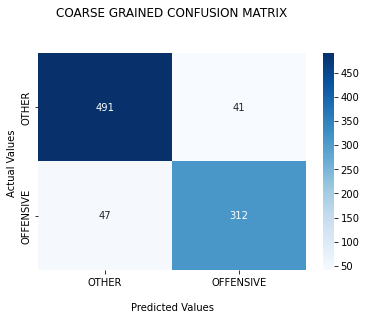

In [ ]:

cf_matrix = metrics.confusion_matrix(Y_testCG, y_predCG)

cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds', fmt='.2f')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
ax.set_title('COARSE GRAINED CONFUSION MATRIX\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['OTHER','OFFENSIVE'])
ax.yaxis.set_ticklabels(['OTHER','OFFENSIVE'])